In [ ]:
!unzip rs80.zip
!mkdir extra
!rm rs80.zip

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.layers import Input
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

from tqdm.notebook import tqdm

In [4]:
def video_reader(x, end_frame=100):
  cap = cv.VideoCapture(x)
  output = []
  frame_num = 0
  while True:
    ret, frame = cap.read()
    if (ret == None) or (frame_num == end_frame):
      break
    
    output.append(frame)
    frame_num += 1

  # Take every 3rd frame
  idxs = list(range(0, 100, 3))
  output = np.array(output)
  output = output[idxs]
  return output

In [5]:
# Data Loader
class ViolenceDataset():
  NVIO = "/content/rs80/non_violence"
  VIO = "/content/rs80/violence"
  LABELS = {NVIO : 0, VIO : 1}

  training_data = []
  viocount = 0
  nviocount = 0

  # Training set maker func
  def training_maker(self):
    # Loop over each label
    for label in self.LABELS:
      print(label)
      # Loop over label folder
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          # Video reader
          vid = video_reader(path)

          self.training_data.append([np.array(vid), np.eye(2)[self.LABELS[label]]])

          # Label counter
          if label == self.NVIO:
            self.nviocount += 1
          elif label == self.VIO:
            self.viocount += 1
        except Exception as e:
          pass

    # Shuffle data
    np.random.shuffle(self.training_data)
    print("\n")
    print(f"NVIO : {self.nviocount}")
    print(f"VIO  : {self.viocount}")
    
    return self.training_data

In [6]:
dset = ViolenceDataset()
trainset = dset.training_maker()

/content/rs80/non_violence


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app



/content/rs80/violence





NVIO : 1000
VIO  : 1000


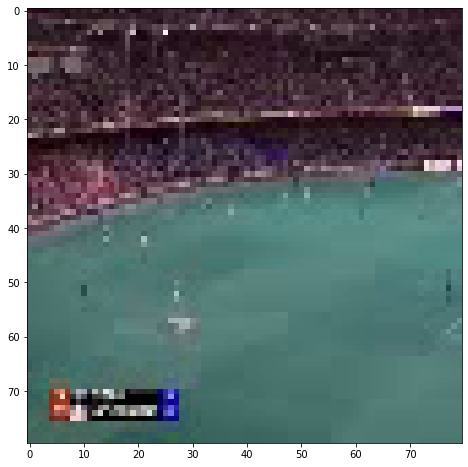

In [7]:
plt.figure(figsize=(15,8))
plt.imshow(trainset[0][0][0])
plt.show()

In [8]:
effb0 = keras.applications.efficientnet.EfficientNetB0(include_top=False, input_shape=(80, 80, 3))

16711680/16705208 [==============================] - 0s 0us/step


In [9]:
# Index counter
counter = 0

# Loop over dataset 
for idx in tqdm(range(len(trainset))):
  sequence = []

  # Loop over video data
  for frame in trainset[idx][0]:
    try:
      # Reshape frame for eff0
      frame = frame.reshape((1, 80, 80, 3))

      # Take eff0 output
      prediction = effb0.predict(frame)
      #print(prediction.shape)
      # Reshape output for lstm
      prediction = prediction.reshape((1,3, 3, 1280))

      # Add prediction to sequence list
      sequence.append(prediction)
    except:
      pass
  
  # Change list type to numpy array
  sequence = np.array(sequence)

  # Save output for later usage
  np.save(f"extra/video-{counter}.npy", [sequence, trainset[idx][1]])
  counter += 1

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [10]:
del sequence
del trainset

In [11]:
data_paths = os.listdir("/content/extra")

In [12]:
# Create label and features
data_x = []
data_y = []

# Loop over folder
for i in tqdm(data_paths):
  
  # Load saved data
  temp_data = np.load("/content/extra/" + i, allow_pickle=True)
  
  # if frames more than 34
  if temp_data[0].shape[0] >= 34:

    # Add videos' first 100 frames to list
    data_x.append(temp_data[0][0:34])

    # Take label
    data_y.append(temp_data[1])

# Change list to numpy array
data_x = np.array(data_x)
data_y = np.array(data_y)

print("\n")
print(f"X len : {len(data_x)}")
print(f"Y len : {len(data_y)}")




X len : 1857
Y len : 1857


In [13]:
!rm -r extra

In [14]:
#data_x = [i for i in data_x]

In [15]:
data_x.shape

(1857, 34, 1, 3, 3, 1280)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=42)

In [17]:
del data_x
del data_y

In [18]:
def build_efflstm():
  model = keras.models.Sequential([keras.layers.Reshape(target_shape=((34, -1)), input_shape=(34, 1, 3, 3, 1280)),
                                   keras.layers.LSTM(100, recurrent_dropout=0.1),

                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.Dropout(0.3),

                                   keras.layers.Dense(2, activation='sigmoid')
  ])

  return model

eff0_lstm = build_efflstm()

eff0_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
x_train[0].shape

(34, 1, 3, 3, 1280)

In [20]:
hist_eff0 = eff0_lstm.fit(x_train, y_train, epochs=10, validation_split=0.25)

Epoch 1/10
33/33 [==============================] - 56s 2s/step - loss: 0.4415 - accuracy: 0.8103 - val_loss: 0.3236 - val_accuracy: 0.8621
Epoch 2/10
33/33 [==============================] - 56s 2s/step - loss: 0.1870 - accuracy: 0.9339 - val_loss: 0.2744 - val_accuracy: 0.8851
Epoch 3/10
33/33 [==============================] - 53s 2s/step - loss: 0.1122 - accuracy: 0.9636 - val_loss: 0.2519 - val_accuracy: 0.8908
Epoch 4/10
33/33 [==============================] - 53s 2s/step - loss: 0.0503 - accuracy: 0.9818 - val_loss: 0.3156 - val_accuracy: 0.8994
Epoch 5/10
33/33 [==============================] - 61s 2s/step - loss: 0.0179 - accuracy: 0.9971 - val_loss: 0.2479 - val_accuracy: 0.9253
Epoch 6/10
33/33 [==============================] - 56s 2s/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.2577 - val_accuracy: 0.9195
Epoch 7/10
33/33 [==============================] - 54s 2s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.2962 - val_accuracy: 0.9253
Epoch 8/10
33/33 [==

In [21]:
eff0_lstm.evaluate(x_test, y_test)

15/15 [==============================] - 8s 558ms/step - loss: 0.5455 - accuracy: 0.8882


[0.5454533696174622, 0.8881720304489136]

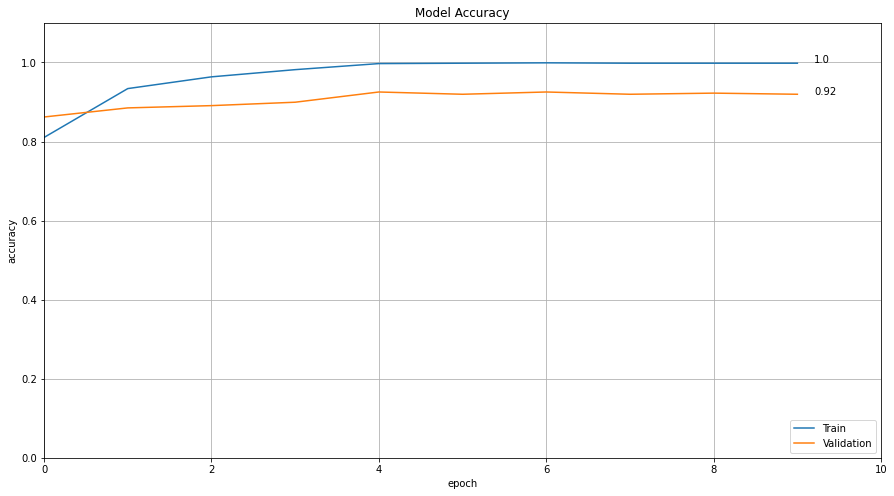

In [22]:
# Plot train and validation accuracy
plt.figure(figsize=(15,8))
plt.plot(hist_eff0.history['accuracy'])
plt.text(9.2, hist_eff0.history['accuracy'][-1], str(round(hist_eff0.history['accuracy'][-1], 2)))
plt.plot(hist_eff0.history['val_accuracy'])
plt.text(9.2, hist_eff0.history['val_accuracy'][-1], str(round(hist_eff0.history['val_accuracy'][-1], 2)))

plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.xlim((0,10))
plt.ylim((0,1.1))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()